# Optical Rotation and Rotation Noise Measurement (HYBRID PUMPING)

PDB measured with Spectrum Analyzer with an aliasing (RSE) filter (AI 3) of f3db = 482 kHz (33 ohms and 10nF).

In [ ]:
#import one_ring.daq.nidaqmx_tools as ndaq
#import one_ring.daq.thorlabs as thor

In [8]:
from one_ring.base.pint_units import ureg
import matplotlib.pyplot as plt
import one_ring.base.fitting_tools as fitt
import numpy as np
import one_ring.base.pandas_tools as pdt
import pandas as pd
plt.style.use('dark_background')
%matplotlib widget

outfname = "../data/rotation_noise.h5"

## Optical Rotation of Blue Laser

Note that the differential power you get from the balanced photodetector is equal to the incident power and , with small rotation angles, 2 theta

$$ 
P_{diff} = P_0 2 sin{\theta} ~= P_0 2 \theta
$$

$P_{diff}$ is also equal to the differential current through the photodiodes, which are turned into some voltage through some z as defined by the BPD's datasheet. But  mor eimportantly, P0 is dependent on $\eta_{eff}$, which is how efficiently you have the light entering the diodes.\

For a given efficiency of incident power (certain alignment of lasers), the optical rotation is proportional to some constant 

In [ ]:
0.175 * ureg.A/ureg.W
175 * ureg.kV/ureg.A

# BPD monitor

In [ ]:
fs = 100 * ureg.Hz #f3dB is 159kHz
dt = 1/fs
PDB_Monitor = ndaq.DAQViewer(dt)

In [ ]:
PDB_Monitor.configure_channels()

In [ ]:
PDB_Monitor.display()

# Measuring Rotation Calibration

### Initialization

In [9]:
ih5paths = pdt.InteractiveHDF5Paths(outfname, 2)
ih5paths.display_widgets()

GridspecLayout(children=(Select(description='level_0', layout=Layout(grid_area='widget001'), options=('05_08_2…

Output()

In [10]:
#finite measurement for measuring the voltage of the BPD
fm = ndaq.FiniteMeasurement(2*ureg.s,200)
#initialize the dataframe for data collection
df = pd.DataFrame(columns = ['Power [uW]', 'Angle [deg]','Voltage [V]','Voltage err [V]'])
#initialize thorlabs powermeter
pwr_mon = thor.PM100DPowerMeter('USB0::0x1313::0x8078::P0049964::INSTR')
#select your wavelength for this measurement.
pwr_mon.wavelength = 770

NameError: name 'ndaq' is not defined

In [ ]:
#configure it to the right input of the DAQ
fm.configure_channels()

### Taking Data

In [ ]:
#measure power incoming
pwr = pwr_mon.get_power().to(ureg.mW)
pwr

In [ ]:
#measure the angle on polarizer
angle = 204 * ureg.deg

In [ ]:
#measure the voltage on BPD
datapoint = fm.measure_average()

In [ ]:
#unpack voltage measurment
voltage_meas, voltage_err = fm.unpack_averaged_measurements(datapoint)
voltage_meas

In [ ]:
#add a new row on dataframe
df.loc[0] = [pwr.to(ureg.mW).m, angle.to(ureg.deg).m, voltage_meas[0].to(ureg.V).m, voltage_err[0].to(ureg.V).m]

### Saving data

In [ ]:
metadata = {"probe_laser_current": 65*ureg.mA,
            "probe_power": "varies",
            "pump_laser_current": 0*ureg.mA,
            "pump_temp": ureg.Quantity(20.705, ureg.degC),
            "probe_temp": ureg.Quantity(16.902, ureg.degC),
            "beam sampler ratio": 0,
            "cell_temperature": ureg.Quantity(0, ureg.degC),
            "By_field": 0*ureg.uT,
            "Bx_field": 0*ureg.uT,
            "Bz_field": 0*ureg.uT,
            "Bx_field_AC_amp":0 * ureg.uT,
            "func_gen_amp": 0*ureg.mV,
            "Bx_ac_freq": 0*ureg.Hz,
            "mod_points": 0,
            "time_const": 0, 
            "misc_notes": "optical rotation calibration raw data, different powers of probe laser calibration. part of polarization measurements for wulgang to optimize polariation measurement set up and estimating Lx of cell"}

In [5]:
pdt.save_dataframe(outfname, "wulgang_01_11_25_raw_calibration_data", final_df, metadata)

NameError: name 'final_df' is not defined

### Calculating calibration values and making processed calibration data

In [92]:
df_init = pd.DataFrame(columns = ['Power avg [uW]','Power err [uW]',
                                  'Calib [deg/V]','Calib err [deg/V]',
                                  'fit r2'])

In [93]:
#fig, ax = plt.subplots()
for i, m in enumerate(load_df['Power bin'].unique()):
    binned_df = load_df[load_df['Power bin'] == m]
    x = binned_df['Voltage [V]'].to_numpy()
    y = binned_df['Angle [deg]'].to_numpy()
    yerr = binned_df['Angle err [deg]'].to_numpy()
    fit_result = fitt.fit_line(x, y, yerr)

    pwr = binned_df['Power [uW]'].mean()
    pwr_err = binned_df['Power [uW]'].std()
    calib = fit_result.fit_parameters['slope']
    calib_err = fit_result.fit_error['slope']
    r2 = fit_result.r2
    fit_result.plot_fit(fkwargs={'color':'C'+str(i)})
    pwr_bin = m
    df_init.loc[i] = [pwr, pwr_err, calib, calib_err, r2]
#plt.show()

In [84]:
metadata = {"misc_notes": "analyzed version of wulgang_01_11_25_raw_calibration_data. Note that the measurements for 1.2mW is negative. This may be because I had to rotate the polarizer and 1/2  wave plate a lot in order to get it to be a consistent power through all voltages of calibration. I believe you can just take the abs value of the calibration" }

In [85]:
pdt.save_dataframe(outfname, "wulgang_01_11_25_analyzed_calibration_data", df_analyzed, metadata)

# Rotation Calibration Dataviewer

In [11]:
ih5paths = pdt.InteractiveHDF5Paths(outfname, 2)
ih5paths.display_widgets()

GridspecLayout(children=(Select(description='level_0', layout=Layout(grid_area='widget001'), options=('05_08_2…

Output()

In [12]:
raw_df = pdt.load_dataframe(outfname, "wulgang_01_11_25_raw_calibration_data")

In [13]:
calib_df = pdt.load_dataframe(outfname, "wulgang_01_11_25_analyzed_calibration_data")
x_plot = calib_df['Power avg [uW]']
y_plot = np.abs(calib_df['Calib [deg/V]'])
yerr_plot = np.abs(calib_df['Calib err [deg/V]'])

In [14]:
calib_df

,Power avg [uW],Power err [uW],Calib [deg/V],Calib err [deg/V],fit r2
0,0.803359,0.006644,0.561911,0.016600,0.994325
1,1.031182,0.025407,0.619021,0.005686,0.999831
2,1.220127,0.027425,-0.343385,0.012067,0.996309
3,1.601886,0.012377,0.317520,0.008075,0.998708
4,1.811087,0.007046,0.211131,0.004378,0.994340
5,2.029616,0.009897,0.232170,0.007139,0.993564


{'slope': -0.4116033023336704, 'intercept': 0.9891092207655071} 0.7241163583038517


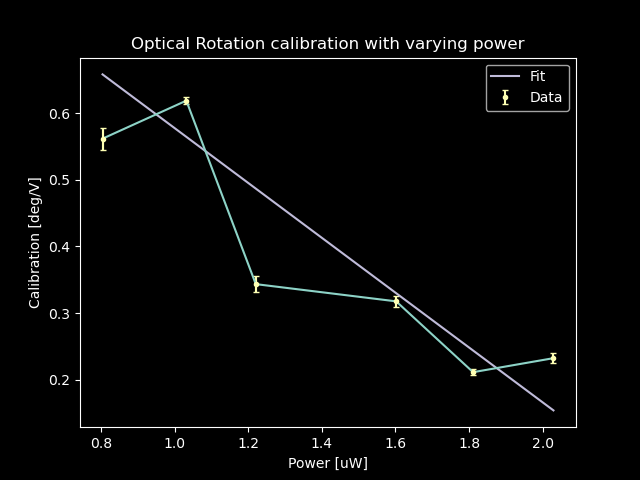

In [15]:
fig, ax = plt.subplots()
ax.errorbar(x_plot, y_plot, yerr_plot)
fit_result = fitt.fit_line(x_plot, y_plot, yerr_plot)
fit_result.plot_fit()
print(fit_result.fit_parameters, fit_result.r2 )
plt.title('Optical Rotation calibration with varying power')
ax.set_xlabel('Power [uW]')
ax.set_ylabel('Calibration [deg/V]')
plt.show()

In [9]:
(calib_df['Calib [deg/V]'][1] * ureg.deg/ureg.V).to(ureg.rad/ureg.V)

<Quantity(0.0108039593, 'radian / volt')>

# Rotation Noise

In [ ]:
ih5paths = pdt.InteractiveHDF5Paths(outfname, 2)
ih5paths.display_widgets()

In [ ]:
raw_data = pdt.load_dataframe(outfname, '05_08_2025/probe_noise_2')
electronic_noise = pdt.load_dataframe(outfname, '05_08_2025/pdb_noise')
electronic_noise_2 = pdt.load_dataframe(outfname, '05_08_2025/pdb_noise_2')
daq_noise = pdt.load_dataframe(outfname, '05_08_2025/daq_noise')
daq_noise_2 = pdt.load_dataframe(outfname, '05_08_2025/daq_noise_2')

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()
ax2.loglog(raw_data['channel0'].index.to_numpy()[0:482000],electronic_noise['channel0'].to_numpy()[0:482000])
ax.loglog(raw_data['channel0'].index.to_numpy()[0:482000],electronic_noise['channel0'].to_numpy()[0:482000] * ureg.V/ureg.Hz**0.5 / rot_calib)

ax.set_ylabel('Rotation Noise [deg/sqrtHz]')
ax2.set_ylabel('Uncalibrated Noise [V/sqrtHz]')
ax.set_xlabel('Frequency [Hz]')
plt.title('05_08_2025 electronic noise contributution\nCalibration = {}'.format(rot_calib))
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()
ax2.loglog(raw_data['channel0'].index.to_numpy()[0:482000],daq_noise['channel0'].to_numpy()[0:482000])
ax.loglog(raw_data['channel0'].index.to_numpy()[0:482000],daq_noise['channel0'].to_numpy()[0:482000] * ureg.V/ureg.Hz**0.5 / rot_calib)

ax.set_ylabel('Rotation Noise [deg/sqrtHz]')
ax2.set_ylabel('Uncalibrated Noise [V/sqrtHz]')
ax.set_xlabel('Frequency [Hz]')
plt.title('05_08_2025 daq noise contributution\nCalibration = {}'.format(rot_calib))
plt.tight_layout()
plt.show()

In [ ]:
pdt.get_node_attr('rotation_noise.h5','05_08_2025/probe_noise_2')

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax2 = ax.twinx()
ax2.loglog(raw_data['channel0'].index.to_numpy()[0:482000],raw_data['channel0'].to_numpy()[0:482000],alpha=0.5)
ax2.loglog(electronic_noise['channel0'].index.to_numpy()[0:482000],electronic_noise['channel0'].to_numpy()[0:482000],alpha=0.5)
ax2.loglog(daq_noise['channel0'].index.to_numpy()[0:482000],daq_noise['channel0'].to_numpy()[0:482000],alpha=0.5)
#ax.loglog(raw_data['channel0'].index.to_numpy()[0:482000],raw_data['channel0'].to_numpy()[0:482000] * ureg.V/ureg.Hz**0.5 / rot_calib)

ax.set_ylabel('Rotation Noise [deg/sqrtHz]')
ax2.set_ylabel('Uncalibrated Noise [V/sqrtHz]')
ax.set_xlabel('Frequency [Hz]')
plt.title('05_08_2025 Rotation Noise\nCalibration = {}'.format(rot_calib))
plt.tight_layout()
plt.show()

In [ ]:
PDB_Monitor.display()

In [ ]:
print('{:.4}'.format(PDB_Monitor.get_data().mean().iloc[0] * ureg.V))

In [ ]:
volt_array = np.array([-8.0, 0.8697, 10.04])
deg_array = np.array([16, 24, 32])

In [ ]:
fig, ax = plt.subplots()
line_fit = fitt.fit_line(deg_array,volt_array)
line_fit.plot_fit()
plt.title('1mW probe power K laser')
plt.show()
print('slope = {} V/deg'.format(line_fit.fit_parameters['slope']))


In [ ]:
line_fit.r2

In [ ]:
power_array = np.array([5.99, 4.99, 4, 3, 2, 1]) * ureg.mW
calib_array = np.array([4.28825, 3.9875, 3.137, 2.411, 1.574, 0.80941]) * ureg.V/ureg.deg
r2 = np.array([0.999, 0.999, 0.998, 0.999, 0.999, 0.999])

In [ ]:
fig, ax = plt.subplots()
line_fit_2 = fitt.fit_line(power_array,calib_array)
line_fit_2.plot_fit()
plt.show()
print(line_fit_2.fit_parameters['slope'])
print(line_fit_2.r2)